<>:32: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:32: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
/var/folders/q0/n2m_wdk56vqcbt6h62ljwtjc0000gn/T/ipykernel_16334/1999621658.py:32: SyntaxWarning: invalid escape sequence '\d'
  unique_restaurants['postal_code'] = unique_restaurants['postal_code'].astype(str).str.extract('(\d+)')
/var/folders/q0/n2m_wdk56vqcbt6h62ljwtjc0000gn/T/ipykernel_16334/1999621658.py:33: SyntaxWarning: invalid escape sequence '\d'
  dutch_postal_codes_df['Postcode'] = dutch_postal_codes_df['Postcode'].astype(str).str.extract('(\d+)')


Total number of unique restaurants: 2716


/var/folders/q0/n2m_wdk56vqcbt6h62ljwtjc0000gn/T/ipykernel_16334/1999621658.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_restaurants['postal_code'] = unique_restaurants['postal_code'].astype(str).str.extract('(\d+)')


Final count of unique restaurants after remapping: 2716
Top 20 Cities by Number of Unique Restaurants (Deliveroo):
1. ANTWERPEN: 790
2. GENT: 452
3. LEUVEN: 242
4. BRUGGE: 226
5. KORTRIJK: 116
6. MECHELEN: 111
7. HASSELT: 80
8. UKKEL: 61
9. OOSTENDE: 57
10. SCHAARBEEK: 54
11. WATERLOO: 45
12. BRUSSEL: 42
13. SINT-LAMBRECHTS-WOLUWE: 37
14. ROESELARE: 36
15. JETTE: 35
16. AALST: 35
17. SINT-PIETERS-WOLUWE: 35
18. SINT-NIKLAAS: 29
19. EVERE: 26
20. GENK: 24
21. TURNHOUT: 17
22. VILVOORDE: 16
23. SINT-AGATHA-BERCHEM: 15
24. SINT-TRUIDEN: 14
25. KRAAINEM: 13
26. VORST: 13
27. SINT-JANS-MOLENBEEK: 11
28. DENDERMONDE: 11
29. GANSHOREN: 9
30. MORTSEL: 8
31. OUDERGEM: 6
32. GRIMBERGEN: 6
33. DROGENBOS: 5
34. WIJNEGEM: 4
35. WEMMEL: 4
36. ZAVENTEM: 3
37. SCHOTEN: 3
38. SINT-PIETERS-LEEUW: 3
39. MACHELEN: 3
40. WEZEMBEEK-OPPEM: 2
41. KNOKKE-HEIST: 2
42. DILBEEK: 2
43. DESTELBERGEN: 1
44. WOMMELGEM: 1
45. BIERBEEK: 1
46. BORSBEEK: 1
47. OUD-TURNHOUT: 1
48. RIXENSART: 1
49. HERENT: 1
50. SINT-JOOST

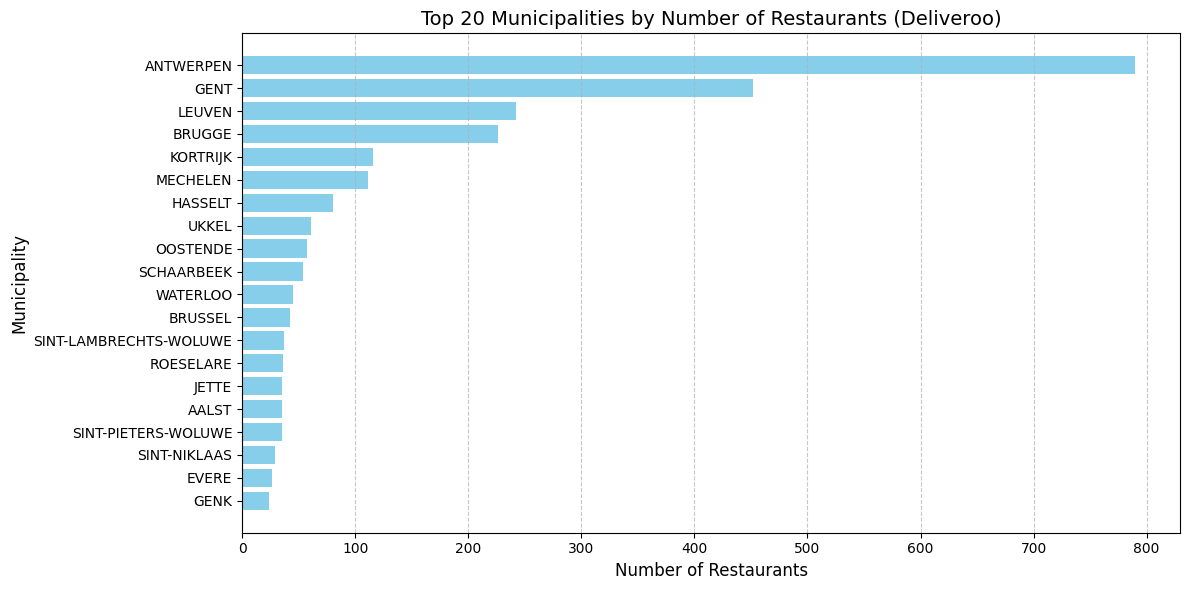

In [52]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# File paths
db_path = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/deliveroo.db"
dutch_postal_codes_file = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/CSV/FROM IMAD/zipcodes_num_nl_new_Tumi.xls"

# Count unique restaurants from the database
conn = sqlite3.connect(db_path)
restaurant_count_query = """
    SELECT 
        r.id AS restaurant_id,
        r.postal_code AS postal_code,
        l.name AS location_name
    FROM restaurants AS r
    LEFT JOIN locations_to_restaurants AS lr ON r.id = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.id;
"""
restaurant_data = pd.read_sql_query(restaurant_count_query, conn)
conn.close()

# Remove duplicates to get the accurate count
unique_restaurants = restaurant_data.drop_duplicates(subset=['restaurant_id'])
total_restaurants = len(unique_restaurants)
print(f"Total number of unique restaurants: {total_restaurants}")

# Load the Dutch postal codes dataset
dutch_postal_codes_df = pd.read_excel(dutch_postal_codes_file)

# Normalize and clean postal codes
unique_restaurants['postal_code'] = unique_restaurants['postal_code'].astype(str).str.extract('(\d+)')
dutch_postal_codes_df['Postcode'] = dutch_postal_codes_df['Postcode'].astype(str).str.extract('(\d+)')

# Remap missing or '0' locations using the postal code from the external CSV
remapped_restaurants_df = pd.merge(
    unique_restaurants,
    dutch_postal_codes_df[['Postcode', 'MAIN MUNICIPALITY']],
    left_on='postal_code',
    right_on='Postcode',
    how='left'
)

# Deduplicate to ensure unique restaurant IDs
remapped_restaurants_df = remapped_restaurants_df.drop_duplicates(subset=['restaurant_id'])

# Replace missing or '0' location names with the MAIN MUNICIPALITY from postal codes
remapped_restaurants_df['location_name'] = remapped_restaurants_df['location_name'].fillna(remapped_restaurants_df['MAIN MUNICIPALITY'])
remapped_restaurants_df.drop(columns=['Postcode'], inplace=True)

# Final count of unique restaurants
final_restaurant_count = len(remapped_restaurants_df)
print(f"Final count of unique restaurants after remapping: {final_restaurant_count}")

# Group by municipality and count restaurants
restaurants_per_municipality = remapped_restaurants_df.groupby('MAIN MUNICIPALITY')['restaurant_id'].count().reset_index()
restaurants_per_municipality.columns = ['Municipality', 'Restaurant Count']
restaurants_per_municipality = restaurants_per_municipality.sort_values(by='Restaurant Count', ascending=False)

# Display top 20 municipalities by restaurant count
print("Top 20 Cities by Number of Unique Restaurants (Deliveroo):")
for idx, (municipality, count) in enumerate(zip(restaurants_per_municipality['Municipality'], restaurants_per_municipality['Restaurant Count']), start=1):
    print(f"{idx}. {municipality}: {count}")

top_20_municipalities = restaurants_per_municipality.head(20)

# Plot the top 20 municipalities
plt.figure(figsize=(12, 6))
plt.barh(top_20_municipalities['Municipality'], top_20_municipalities['Restaurant Count'], color='skyblue')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Municipality', fontsize=12)
plt.title('Top 20 Municipalities by Number of Restaurants (Deliveroo)', fontsize=14)
plt.gca().invert_yaxis()  # Highest count at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the chart
plt.show()


Total number of restaurants before the merge: 4071

Exported 0 rows with missing postal codes to 'missing_postal_codes.csv'.
Total number of restaurants after computing province and region: 4071
Total number of restaurants after the merge: 4071

Top 20 Locations by Number of Unique Restaurants (Takeaway):
                city  restaurant_count
0            SCHOTEN               437
1               GENT               309
2               ASSE               264
3             LEUVEN               174
4              EVERE               110
5            BEERNEM                96
6            BREDENE                85
7           MECHELEN                84
8              EVERE                84
9          ANTWERPEN                56
10         LINKEBEEK                51
11         LINKEBEEK                50
12             EVERE                48
13             EVERE                43
14           HASSELT                41
15  SINT-GILLIS-WAAS                39
16             AALST          

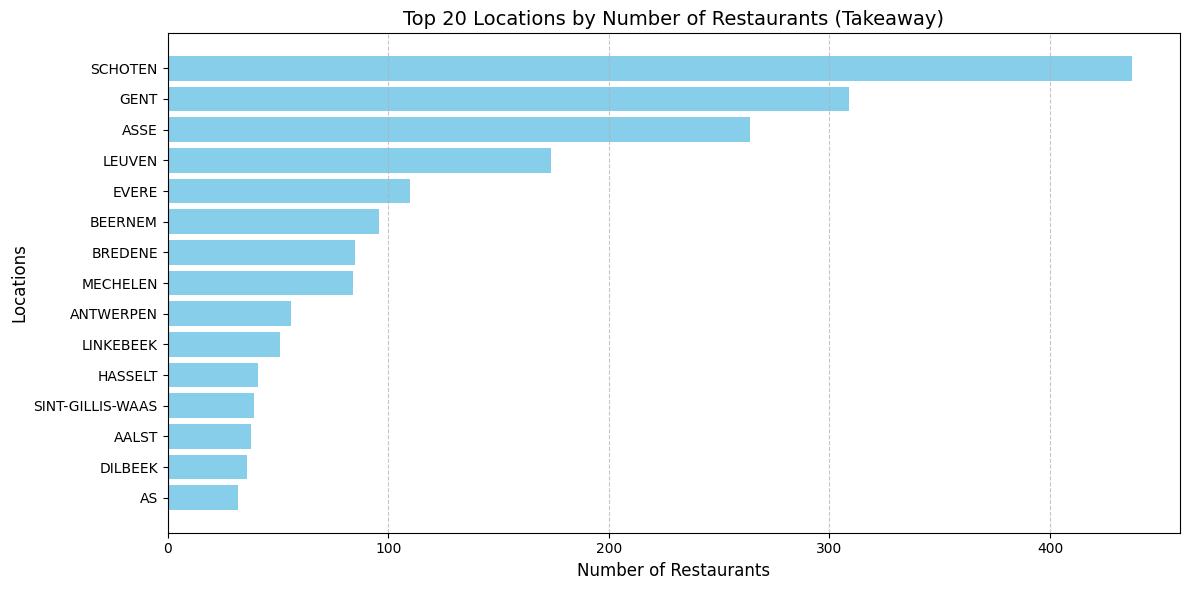

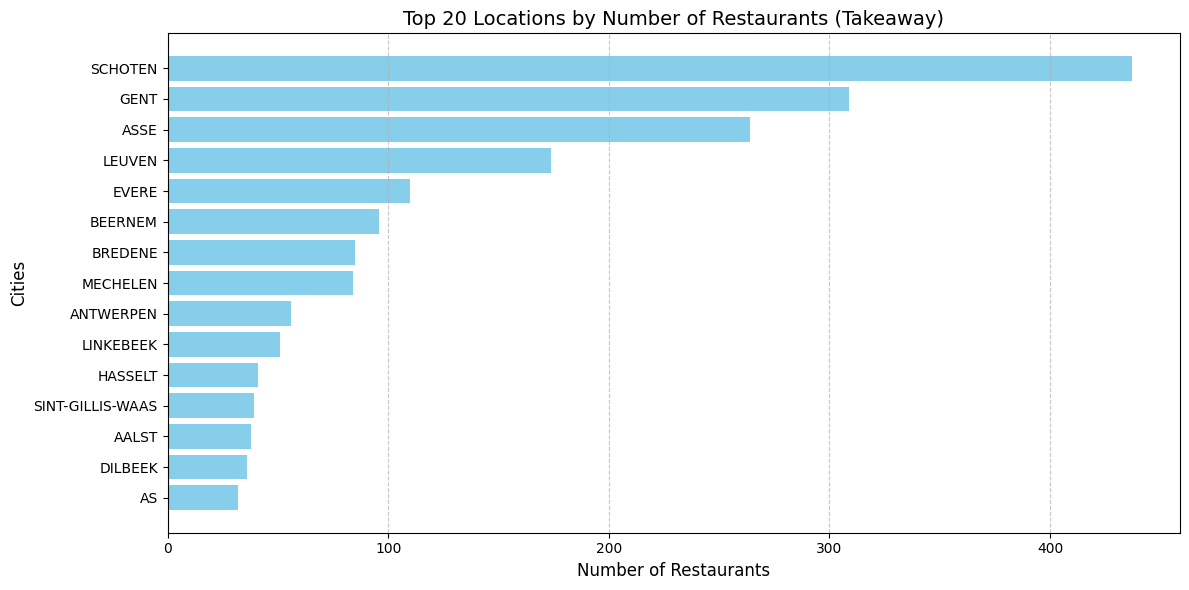

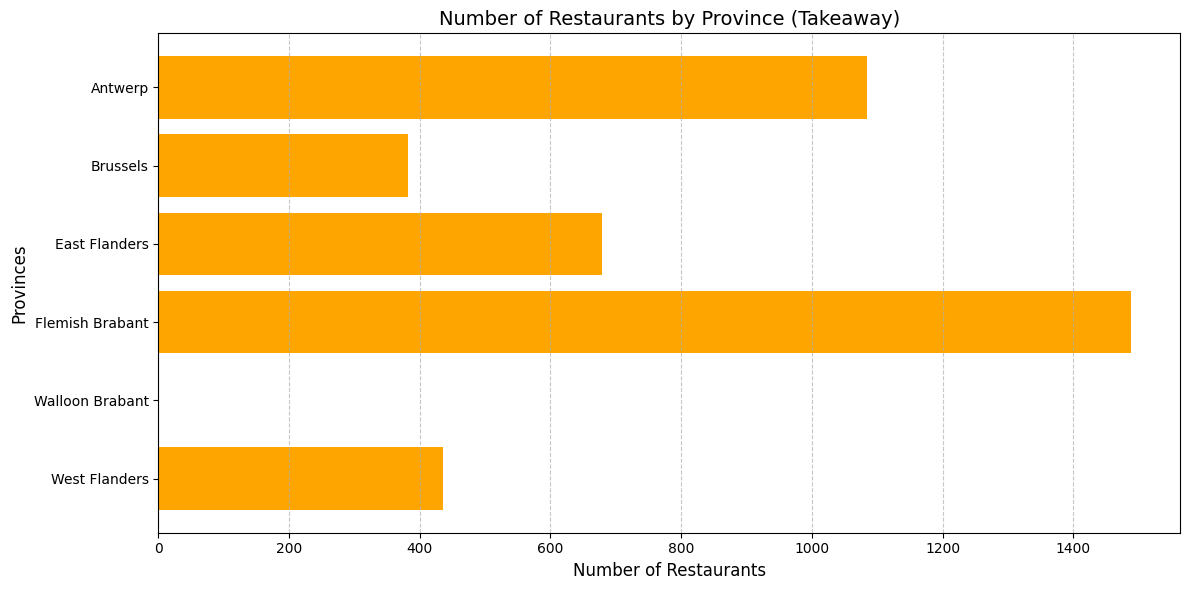

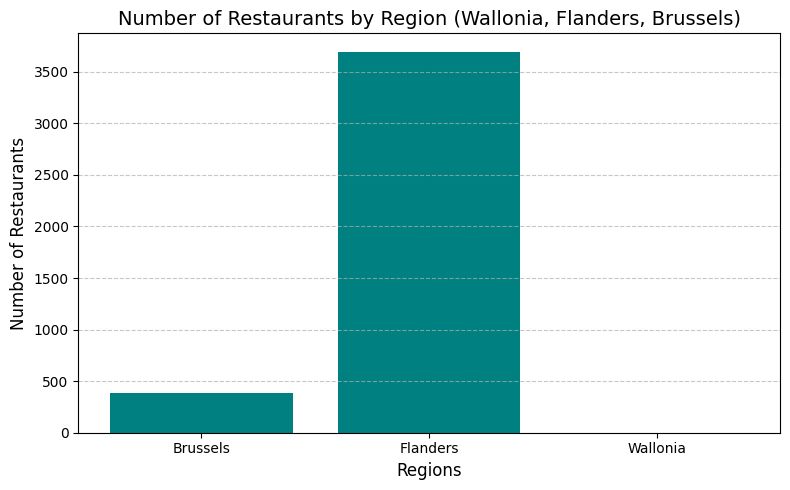

In [53]:
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd

# File paths
db_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/takeaway.db'
csv_path = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/zipcodes_num_nl_new_Tumi.csv"

# Step 1: Connect to the database
con = sqlite3.connect(db_path)

# Step 2: SQL query to include city and postalCode
takeaway_restaurant_distribution = """
    SELECT 
        l.postalCode AS postal_code,
        r.city AS city,
        COUNT(DISTINCT r.restaurant_id) AS restaurant_count
    FROM restaurants AS r
    LEFT JOIN locations_to_restaurants AS lr ON r.primarySlug = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.ID
    GROUP BY r.city
    ORDER BY restaurant_count DESC;
"""

# Execute the query and fetch results
t_distribution_results = pd.read_sql_query(takeaway_restaurant_distribution, con)
con.close()

# Step 3: Count before the merge
print(f"Total number of restaurants before the merge: {t_distribution_results['restaurant_count'].sum()}")

# Step 4: Load the external CSV
postal_codes_df = pd.read_csv(csv_path, sep=';')

# Step 5: Deduplicate the CSV
postal_codes_df = postal_codes_df.drop_duplicates(subset=['Postcode'])

# Step 4: Define postal code to province mapping
def assign_province(postal_code):
        try:
            postal_code = int(postal_code)
            if 1000 <= postal_code <= 1299:
                return 'Brussels'
            elif 1300 <= postal_code <= 1499:
                return 'Walloon Brabant'
            elif 1500 <= postal_code <= 1999:
                return 'Flemish Brabant'
            elif 2000 <= postal_code <= 2999:
                return 'Antwerp'
            elif 3000 <= postal_code <= 3999:
                return 'Flemish Brabant'
            elif 4000 <= postal_code <= 4999:
                return 'Liège'
            elif 5000 <= postal_code <= 5999:
                return 'Namur'
            elif 6000 <= postal_code <= 6599:
                return 'Hainaut'
            elif 6600 <= postal_code <= 6999:
                return 'Luxembourg'
            elif 7000 <= postal_code <= 7999:
                return 'Hainaut'
            elif 8000 <= postal_code <= 8999:
                return 'West Flanders'
            elif 9000 <= postal_code <= 9999:
                return 'East Flanders'
            else:
                return 'Unknown'
        except (ValueError, TypeError):
            return 'Unknown'
# Define postal code ranges for regions
def assign_region(Province):
    Brussels = ['Brussels']
    Flanders = ['Antwerp', 'Flemish Brabant', 'East Flanders', 'West Flanders', 'Limburg']
    Wallonia = ['Walloon Brabant', 'Hainaut', 'Liège', 'Luxembourg', 'Namur']
    if Province is None:
        return None
    
    if Province in Brussels:
        return 'Brussels'
    elif Province in Flanders:
        return 'Flanders'
    elif Province in Wallonia:
        return 'Wallonia'
    return 'Unknown'


# Normalize postal codes for merging
t_distribution_results['postal_code'] = t_distribution_results['postal_code'].astype(str).str.extract(r'(\d+)')
postal_codes_df['Postcode'] = postal_codes_df['Postcode'].astype(str).str.extract(r'(\d+)')

# Step 6: Merge query results with CSV
merged_data = pd.merge(
    t_distribution_results,
    postal_codes_df[['Postcode', 'MAIN MUNICIPALITY']],
    left_on='postal_code',
    right_on='Postcode',
    how='left'
)

# Replace city names with municipality names where possible
merged_data['city'] = merged_data['MAIN MUNICIPALITY'].fillna(merged_data['city'])
merged_data = merged_data.drop(columns=['Postcode', 'MAIN MUNICIPALITY'])

#Compute Province & Region
t_distribution_results['Province'] = t_distribution_results['postal_code'].apply(assign_province)
t_distribution_results['Region'] = t_distribution_results['Province'].apply(assign_region)

# Step 6: Identify missing postal codes
missing_postal_codes = t_distribution_results[t_distribution_results['postal_code'].isnull()]

# Export missing postal codes to CSV
missing_postal_codes.to_csv('missing_postal_codes.csv', index=False)
print(f"\nExported {len(missing_postal_codes)} rows with missing postal codes to 'missing_postal_codes.csv'.")

# Step 7: Group by province and calculate restaurant counts
province_grouped = t_distribution_results.groupby('Province', as_index=False)['restaurant_count'].sum()

# Step 8: Group by region and calculate restaurant counts
region_grouped = t_distribution_results.groupby('Region', as_index=False)['restaurant_count'].sum()


# Step 9: Count after computing province and region
print(f"Total number of restaurants after computing province and region: {t_distribution_results['restaurant_count'].sum()}")

# Step 9: Count after the merge
print(f"Total number of restaurants after the merge: {merged_data['restaurant_count'].sum()}")

# Step 10: Display the top 20 locations
top_20_locations = merged_data.sort_values(by='restaurant_count', ascending=False).head(20)
print("\nTop 20 Locations by Number of Unique Restaurants (Takeaway):")
print(top_20_locations[['city', 'restaurant_count']])

# Step 11: Create the bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_20_locations['city'], top_20_locations['restaurant_count'], color='skyblue')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Locations', fontsize=12)
plt.title('Top 20 Locations by Number of Restaurants (Takeaway)', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Step 11: Create the bar chart for the top 20 locations
plt.figure(figsize=(12, 6))
plt.barh(top_20_locations['city'], top_20_locations['restaurant_count'], color='skyblue')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Cities', fontsize=12)
plt.title('Top 20 Locations by Number of Restaurants (Takeaway)', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 12: Create the bar chart for provinces
plt.figure(figsize=(12, 6))
plt.barh(province_grouped['Province'], province_grouped['restaurant_count'], color='orange')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Provinces', fontsize=12)
plt.title('Number of Restaurants by Province (Takeaway)', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 13: Create the bar chart for regions
plt.figure(figsize=(8, 5))
plt.bar(region_grouped['Region'], region_grouped['restaurant_count'], color='teal')
plt.xlabel('Regions', fontsize=12)
plt.ylabel('Number of Restaurants', fontsize=12)
plt.title('Number of Restaurants by Region (Wallonia, Flanders, Brussels)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




Total number of restaurants before the merge: 4071

Exported 0 rows with missing postal codes to 'missing_postal_codes.csv'.
Total number of restaurants after computing province and region: 4071

Top 20 Locations by Number of Unique Restaurants (Takeaway):
                    city  restaurant_count
0              Antwerpen               437
1                   Gent               309
2              Bruxelles               264
3                 Leuven               174
4             Schaerbeek               110
5                 Brugge                96
6               Oostende                85
7               Mechelen                84
8             Anderlecht                84
9                 Deurne                56
10                 Uccle                51
11               Ixelles                50
12                Laeken                48
13             Etterbeek                43
14               Hasselt                41
15          Sint-Niklaas                39
16          

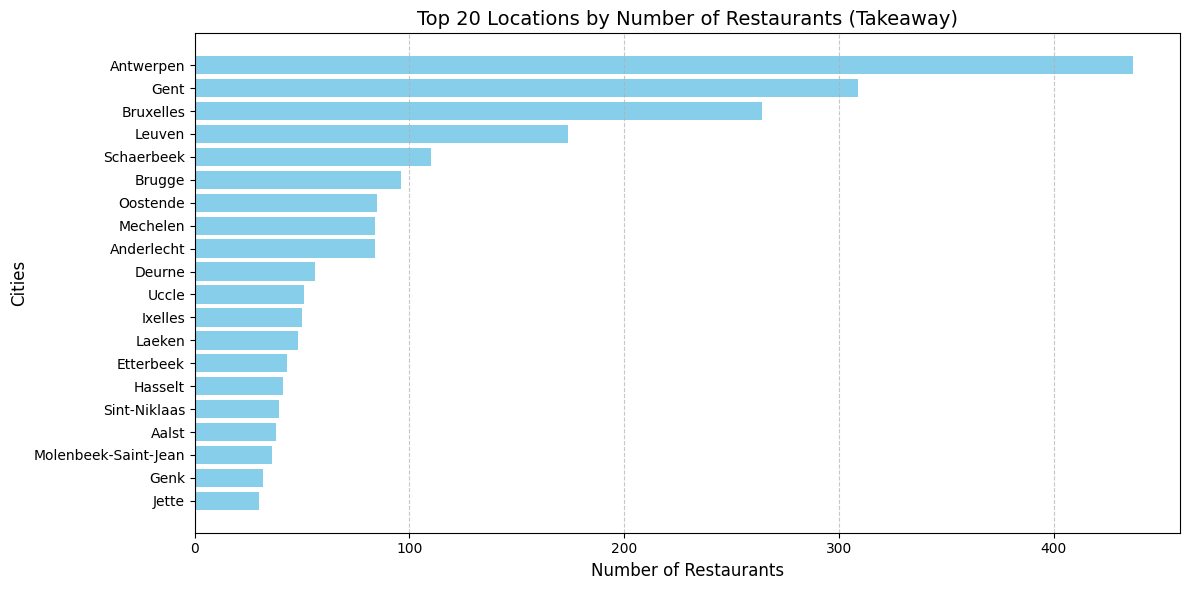

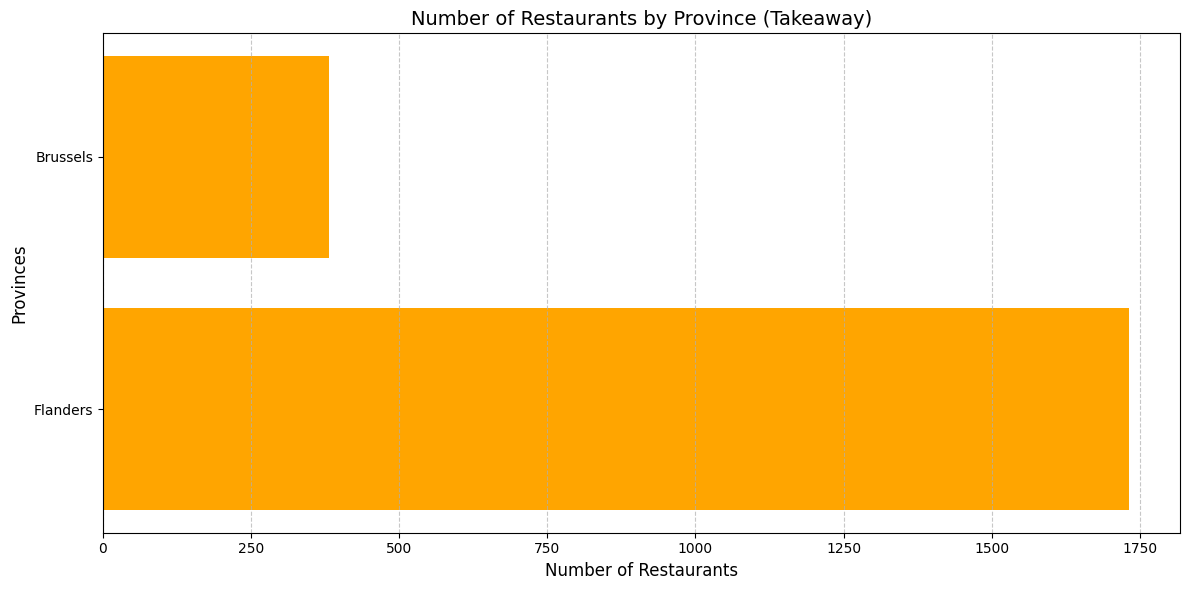

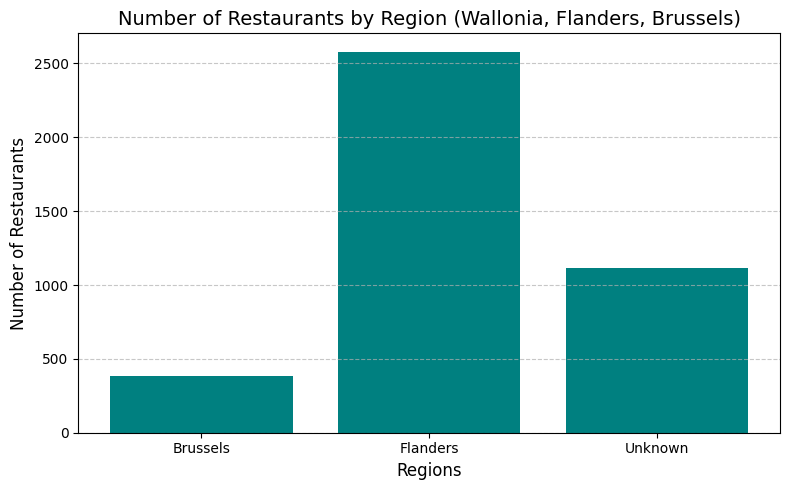

In [1]:
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd

# File paths
db_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/takeaway.db'

# Step 1: Connect to the database
con = sqlite3.connect(db_path)

# Step 2: SQL query to include city and postalCode
takeaway_restaurant_distribution = """
    SELECT 
        l.postalCode AS postal_code,
        r.city AS city,
        COUNT(DISTINCT r.restaurant_id) AS restaurant_count
    FROM restaurants AS r
    LEFT JOIN locations_to_restaurants AS lr ON r.primarySlug = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.ID
    GROUP BY r.city
    ORDER BY restaurant_count DESC;
"""

# Execute the query and fetch results
t_distribution_results = pd.read_sql_query(takeaway_restaurant_distribution, con)
con.close()

# Step 3: Count before the merge
print(f"Total number of restaurants before the merge: {t_distribution_results['restaurant_count'].sum()}")

# Step 4: Define postal code to province mapping
def assign_province(postal_code):
    if postal_code is None:
        return None
    postal_code = int(postal_code)
    if 1000 <= postal_code <= 1299:
        return 'Brussels'
    elif 1300 <= postal_code <= 1499 or 2000 <= postal_code <= 3999:
        return 'Flanders'
    elif 4000 <= postal_code <= 7999:
        return 'Wallonia'
    return None

# Define postal code ranges for regions
def assign_region(postal_code):
    if postal_code is None:
        return None
    postal_code = int(postal_code)
    if 1000 <= postal_code <= 1299:
        return 'Brussels'
    elif 1300 <= postal_code <= 3999:
        return 'Flanders'
    elif 4000 <= postal_code <= 7999:
        return 'Wallonia'
    return 'Unknown'

# Normalize postal codes
t_distribution_results['postal_code'] = t_distribution_results['postal_code'].astype(str).str.extract(r'(\d+)')

# Step 5: Compute province and region
t_distribution_results['Province'] = t_distribution_results['postal_code'].apply(assign_province)
t_distribution_results['Region'] = t_distribution_results['postal_code'].apply(assign_region)

# Step 6: Identify missing postal codes
missing_postal_codes = t_distribution_results[t_distribution_results['postal_code'].isnull()]

# Export missing postal codes to CSV
missing_postal_codes.to_csv('missing_postal_codes.csv', index=False)
print(f"\nExported {len(missing_postal_codes)} rows with missing postal codes to 'missing_postal_codes.csv'.")

# Step 7: Group by province and calculate restaurant counts
province_grouped = t_distribution_results.groupby('Province', as_index=False)['restaurant_count'].sum()

# Step 8: Group by region and calculate restaurant counts
region_grouped = t_distribution_results.groupby('Region', as_index=False)['restaurant_count'].sum()

# Step 9: Count after computing province and region
print(f"Total number of restaurants after computing province and region: {t_distribution_results['restaurant_count'].sum()}")


# Step 10: Display the top 20 locations
top_20_locations = t_distribution_results.sort_values(by='restaurant_count', ascending=False).head(20)
print("\nTop 20 Locations by Number of Unique Restaurants (Takeaway):")
print(top_20_locations[['city', 'restaurant_count']])

# Step 11: Create the bar chart for the top 20 locations
plt.figure(figsize=(12, 6))
plt.barh(top_20_locations['city'], top_20_locations['restaurant_count'], color='skyblue')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Cities', fontsize=12)
plt.title('Top 20 Locations by Number of Restaurants (Takeaway)', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 12: Create the bar chart for provinces
plt.figure(figsize=(12, 6))
plt.barh(province_grouped['Province'], province_grouped['restaurant_count'], color='orange')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Provinces', fontsize=12)
plt.title('Number of Restaurants by Province (Takeaway)', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 13: Create the bar chart for regions
plt.figure(figsize=(8, 5))
plt.bar(region_grouped['Region'], region_grouped['restaurant_count'], color='teal')
plt.xlabel('Regions', fontsize=12)
plt.ylabel('Number of Restaurants', fontsize=12)
plt.title('Number of Restaurants by Region (Wallonia, Flanders, Brussels)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Total number of restaurants before the merge: 4071

Entries with Unknown Region:
Empty DataFrame
Columns: [postal_code, city, restaurant_count]
Index: []
Total count of restaurants in Unknown Region: 0
Total number of unique postal codes in Unknown Region: 0
Exported unknown region data to 'unknown_region_data.csv'.
Total number of restaurants after computing province and region: 4071

Top 20 Locations by Number of Unique Restaurants (Takeaway):
                    city  restaurant_count
0              Antwerpen               437
1                   Gent               309
2              Bruxelles               264
3                 Leuven               174
4             Schaerbeek               110
5                 Brugge                96
6               Oostende                85
7               Mechelen                84
8             Anderlecht                84
9                 Deurne                56
10                 Uccle                51
11               Ixelles          

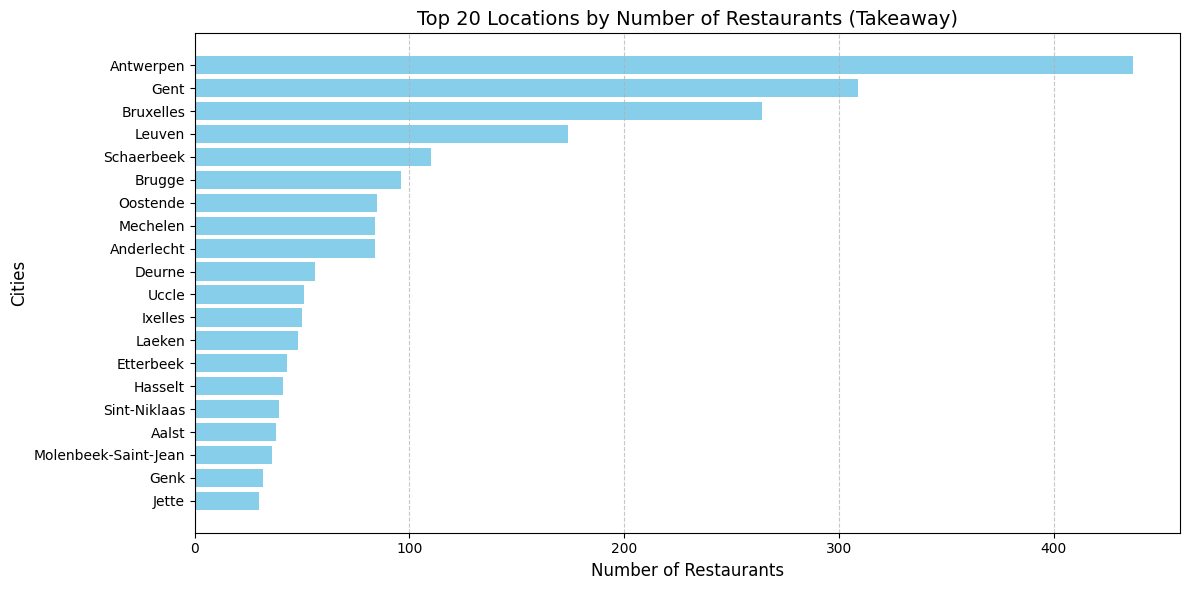

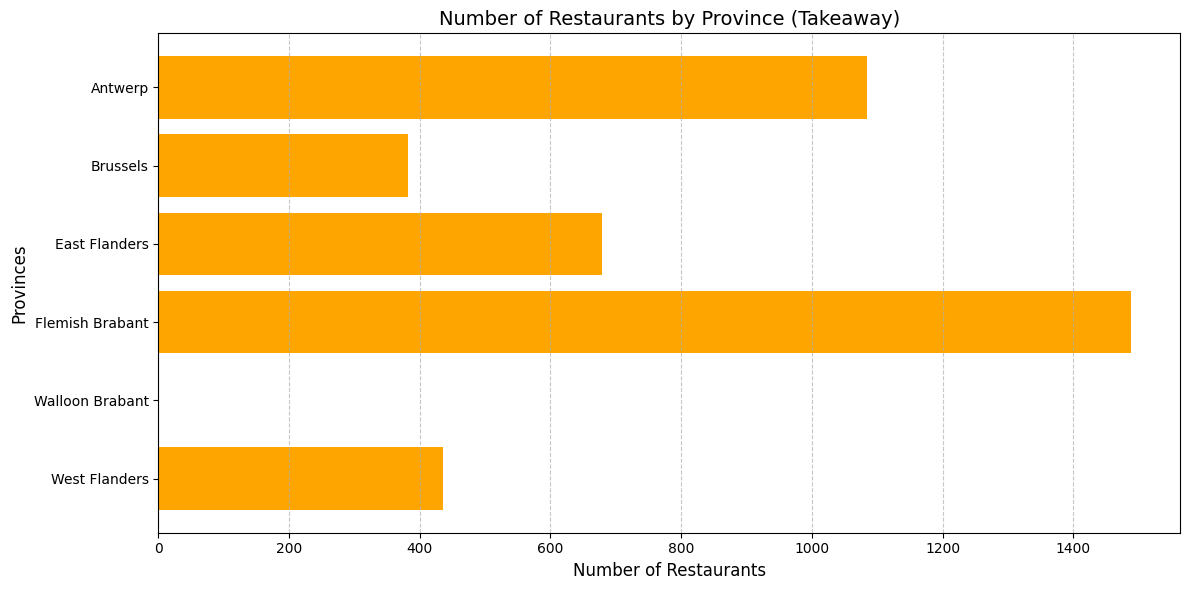

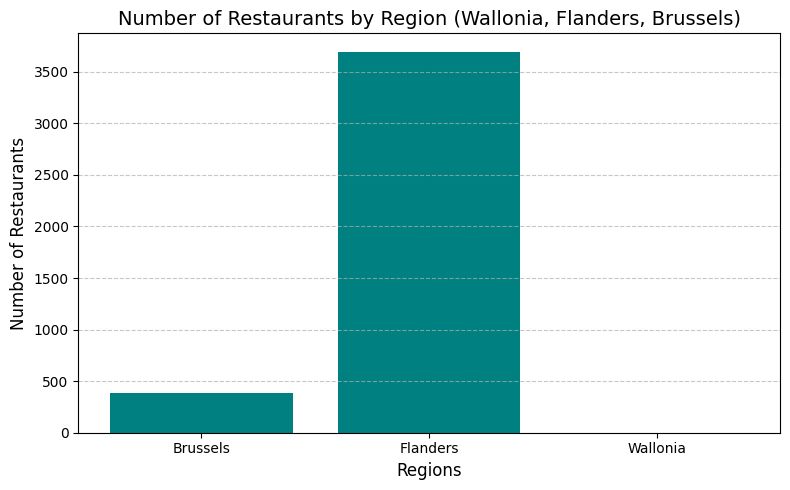

In [2]:
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd

# File paths
db_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/takeaway.db'

# Step 1: Connect to the database
con = sqlite3.connect(db_path)

# Step 2: SQL query to include city and postalCode
takeaway_restaurant_distribution = """
    SELECT 
        l.postalCode AS postal_code,
        r.city AS city,
        COUNT(DISTINCT r.restaurant_id) AS restaurant_count
    FROM restaurants AS r
    LEFT JOIN locations_to_restaurants AS lr ON r.primarySlug = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.ID
    GROUP BY r.city
    ORDER BY restaurant_count DESC;
"""

# Execute the query and fetch results
t_distribution_results = pd.read_sql_query(takeaway_restaurant_distribution, con)
con.close()

# Step 3: Count before the merge
print(f"Total number of restaurants before the merge: {t_distribution_results['restaurant_count'].sum()}")

# Step 4: Define postal code to province mapping
def assign_province(postal_code):
        try:
            postal_code = int(postal_code)
            if 1000 <= postal_code <= 1299:
                return 'Brussels'
            elif 1300 <= postal_code <= 1499:
                return 'Walloon Brabant'
            elif 1500 <= postal_code <= 1999:
                return 'Flemish Brabant'
            elif 2000 <= postal_code <= 2999:
                return 'Antwerp'
            elif 3000 <= postal_code <= 3999:
                return 'Flemish Brabant'
            elif 4000 <= postal_code <= 4999:
                return 'Liège'
            elif 5000 <= postal_code <= 5999:
                return 'Namur'
            elif 6000 <= postal_code <= 6599:
                return 'Hainaut'
            elif 6600 <= postal_code <= 6999:
                return 'Luxembourg'
            elif 7000 <= postal_code <= 7999:
                return 'Hainaut'
            elif 8000 <= postal_code <= 8999:
                return 'West Flanders'
            elif 9000 <= postal_code <= 9999:
                return 'East Flanders'
            else:
                return 'Unknown'
        except (ValueError, TypeError):
            return 'Unknown'
# Define postal code ranges for regions
def assign_region(Province):
    Brussels = ['Brussels']
    Flanders = ['Antwerp', 'Flemish Brabant', 'East Flanders', 'West Flanders', 'Limburg']
    Wallonia = ['Walloon Brabant', 'Hainaut', 'Liège', 'Luxembourg', 'Namur']
    if Province is None:
        return None
    
    if Province in Brussels:
        return 'Brussels'
    elif Province in Flanders:
        return 'Flanders'
    elif Province in Wallonia:
        return 'Wallonia'
    return 'Unknown'

# Normalize postal codes
t_distribution_results['postal_code'] = t_distribution_results['postal_code'].astype(str).str.extract(r'(\d+)')

# Step 5: Compute province and region
t_distribution_results['Province'] = t_distribution_results['postal_code'].apply(assign_province)
t_distribution_results['Region'] = t_distribution_results['Province'].apply(assign_region)

# Step 6: Identify missing or unknown regions
unknown_region_data = t_distribution_results[t_distribution_results['Region'] == 'Unknown']
print("\nEntries with Unknown Region:")
print(unknown_region_data[['postal_code', 'city', 'restaurant_count']].head(10))  # Display first 10 rows
print(f"Total count of restaurants in Unknown Region: {unknown_region_data['restaurant_count'].sum()}")
print(f"Total number of unique postal codes in Unknown Region: {unknown_region_data['postal_code'].nunique()}")

# Export unknown region data to CSV
unknown_region_data.to_csv('unknown_region_data.csv', index=False)
print("Exported unknown region data to 'unknown_region_data.csv'.")

# Step 7: Group by province and calculate restaurant counts
province_grouped = t_distribution_results.groupby('Province', as_index=False)['restaurant_count'].sum()

# Step 8: Group by region and calculate restaurant counts
region_grouped = t_distribution_results.groupby('Region', as_index=False)['restaurant_count'].sum()

# Step 9: Count after computing province and region
print(f"Total number of restaurants after computing province and region: {t_distribution_results['restaurant_count'].sum()}")

# Step 10: Display the top 20 locations
top_20_locations = t_distribution_results.sort_values(by='restaurant_count', ascending=False).head(20)
print("\nTop 20 Locations by Number of Unique Restaurants (Takeaway):")
print(top_20_locations[['city', 'restaurant_count']])

# Step 11: Create the bar chart for the top 20 locations
plt.figure(figsize=(12, 6))
plt.barh(top_20_locations['city'], top_20_locations['restaurant_count'], color='skyblue')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Cities', fontsize=12)
plt.title('Top 20 Locations by Number of Restaurants (Takeaway)', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 12: Create the bar chart for provinces
plt.figure(figsize=(12, 6))
plt.barh(province_grouped['Province'], province_grouped['restaurant_count'], color='orange')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Provinces', fontsize=12)
plt.title('Number of Restaurants by Province (Takeaway)', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 13: Create the bar chart for regions
plt.figure(figsize=(8, 5))
plt.bar(region_grouped['Region'], region_grouped['restaurant_count'], color='teal')
plt.xlabel('Regions', fontsize=12)
plt.ylabel('Number of Restaurants', fontsize=12)
plt.title('Number of Restaurants by Region (Wallonia, Flanders, Brussels)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [35]:
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd

# File paths
db_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/takeaway.db'

# Step 1: Connect to the database
con = sqlite3.connect(db_path)

# Step 2: SQL query to include city and postalCode
takeaway_restaurant_distribution = """
    SELECT 
        l.postalCode AS postal_code,
        r.city AS city,
        COUNT(DISTINCT r.restaurant_id) AS restaurant_count
    FROM restaurants AS r
    LEFT JOIN locations_to_restaurants AS lr ON r.primarySlug = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.ID
    GROUP BY r.city
    ORDER BY restaurant_count DESC;
"""

# Execute the query and fetch results
t_distribution_results = pd.read_sql_query(takeaway_restaurant_distribution, con)
con.close()

# Step 3: Normalize postal codes
t_distribution_results['postal_code'] = t_distribution_results['postal_code'].astype(str).str.extract(r'(\d+)')

# Step 4: Define postal code to province and region mapping
def assign_province(postal_code):
    if postal_code is None:
        return None
    postal_code = int(postal_code)
    if 1000 <= postal_code <= 1299:
        return 'Brussels'
    elif 1300 <= postal_code <= 1499 or 2000 <= postal_code <= 3999:
        return 'Flanders'
    elif 4000 <= postal_code <= 7999:
        return 'Wallonia'
    return None

def assign_region(postal_code):
    if postal_code is None:
        return None
    postal_code = int(postal_code)
    if 1000 <= postal_code <= 1299:
        return 'Brussels'
    elif 1300 <= postal_code <= 3999:
        return 'Flanders'
    elif 4000 <= postal_code <= 7999:
        return 'Wallonia'
    return None

# Step 5: Compute province and region
t_distribution_results['Province'] = t_distribution_results['postal_code'].apply(assign_province)
t_distribution_results['Region'] = t_distribution_results['postal_code'].apply(assign_region)

# Step 6: Identify missing postal codes
missing_postal_codes = t_distribution_results[t_distribution_results['Province'].isnull() | t_distribution_results['Region'].isnull()]

# Step 7: Print missing postal codes for investigation
print("\nMissing Postal Codes:")
print(missing_postal_codes[['postal_code', 'city', 'restaurant_count']])

# Optional: Save missing postal codes to a CSV file for further analysis
missing_postal_codes.to_csv('missing_postal_codes.csv', index=False)

# Step 8: Summary of missing postal codes
print(f"\nTotal number of missing postal codes: {missing_postal_codes['postal_code'].nunique()}")
print(f"Total restaurant count for missing postal codes: {missing_postal_codes['restaurant_count'].sum()}")



Missing Postal Codes:
    postal_code       city  restaurant_count
1          9000       Gent               309
2          1731  Bruxelles               264
5          8730     Brugge                96
6          8450   Oostende                85
10         1630      Uccle                51
..          ...        ...               ...
522        8800    Ardooie                 1
523        9600    Anzegem                 1
526        1760   Affligem                 1
528        8720    Aarsele                 1
529        1820       1040                 1

[267 rows x 3 columns]

Total number of missing postal codes: 97
Total restaurant count for missing postal codes: 1958
